In [1]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np

# ledgame

`ledgame` is a game focusing on puzzles and labyrinth exploration using the 8x8 LED display on the [Sense HAT](https://www.raspberrypi.org/products/sense-hat/) module for the Raspberry Pi. 
To control the character within the game, the player uses the control stick also present on the Sense Hat module. 
The game's levels are PNG images which are parsed, and each pixel in the image becomes a cell within the game.

Certain pixels in the PNG images, when parsed, result in certain mechanics that have been implemented:

* Black pixels become floors
* White pixels become walls
* Blue pixels become the player
    * **Note:** If several blue pixels exists in an image, a random blue pixel is selected as the player's start position
* Gold pixels become gold coins which the player must pick up to clear the level
* Brown pixels become teleports which ports the player to another teleport when stepped on
    * **Note:** If several brown pixels exists in a stage, teleports work in a circle. This means that upon teleporting, the player gets teleported to the next teleporter. Then, upon stepping on the exit teleporter, the player gets teleported to the next in line. 
* Gray pixels become boxes which the player can push around
* Green pixels become keys which the player can pick up
* Purple pixels become doors which are locked until a player tries to unlock it while holding at least one key

We can have a look at the specific colours defined in `ledgame`.

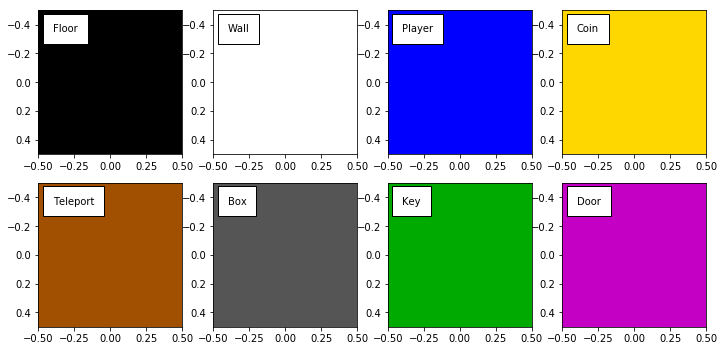

In [2]:
import ledgame

colors = [ledgame.BLACK, ledgame.WHITE, ledgame.BLUE, ledgame.GOLD, 
    ledgame.BROWN, ledgame.GRAY, ledgame.GREEN, ledgame.PURPLE]
labels = ["Floor", "Wall", "Player", "Coin", 
    "Teleport", "Box", "Key", "Door"]

plt.figure(figsize=(12, 9))

for i in range(len(colors)):
    plt.subplot(3, 4, i+1)
    
    plt.imshow(np.array(colors[i]).reshape((1, 1, 3)), interpolation="none")
    plt.text(-0.4,-0.35, labels[i], bbox={'facecolor': 'white', 'pad': 10})

plt.show()

## Developing on the computer

TODO, talk about why we created notpi :)

In [3]:
from ledgame.character import Character
from ledgame.world import World
from notpi import NotPi
from os import path, listdir

pi = NotPi(init_pygame=False)
basepath = path.dirname(path.abspath(ledgame.__file__))
enabled_levels = path.join(basepath, "levels", "enabled")
worlds = [
    file for file 
    in listdir(enabled_levels) 
    if path.isfile(path.join(enabled_levels, file))
]
world_number = 0

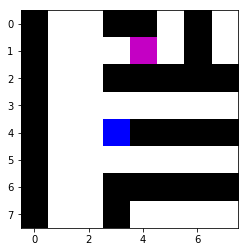

In [4]:
def get_level(filename):
    return path.join(enabled_levels, filename)

def set_level(world_number, char):
    char.total_gold += char.gold
    world = World(get_level(worlds[world_number]))
    char.start(world.player_start)
    return world

def draw(char):
    view = world.view(char)
    pi.set_pixels(view)
    pi.set_pixel(3, 4, char.color)
    pixels = np.array(pi.get_pixels())
    grid = pixels.reshape((8, 8, 3))
    plt.imshow(grid, interpolation="none")
    
char = Character()
world = set_level(world_number, char)
draw(char)

In [5]:
# if we move the character, right we can see the view shifts to the left
button = widgets.Button(description="Go right!")
display(button)

def on_button_clicked(b):
    char.move('right', world)
    draw(char)

button.on_click(on_button_clicked)

Button(description='Go right!', style=ButtonStyle())